In [1]:
pip install pmdarima

In [2]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.5
1.0.2
0.13.2


In [3]:
ls /content/drive/MyDrive/COLAB_data/ 

005930.KS.csv


## STEP 1 : 시계열 데이터 준비
---
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음
- 우린 종가(Close)만 사용

-> 데이터 불러올 때, 시계열로 불러오고(index_col, Parse_dates 사용)  종가만 불러오기

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#구글 코랩 데이터 불러오기
from google.colab import drive
drive.mount("/content/drive")
data_path = '/content/drive/MyDrive/COLAB_data/005930.KS.csv'

# Time Series 생성
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(data_path, index_col='Date', parse_dates=True) #시계열로 불러야하니까 index 및 parse_dates 추가해줌
ts = df['Close']

ts.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Date
2021-05-04    82600.0
2021-05-06    82300.0
2021-05-07    81900.0
2021-05-10    83200.0
2021-05-11    81200.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
---
- 결측치 처리
- 로그 변환

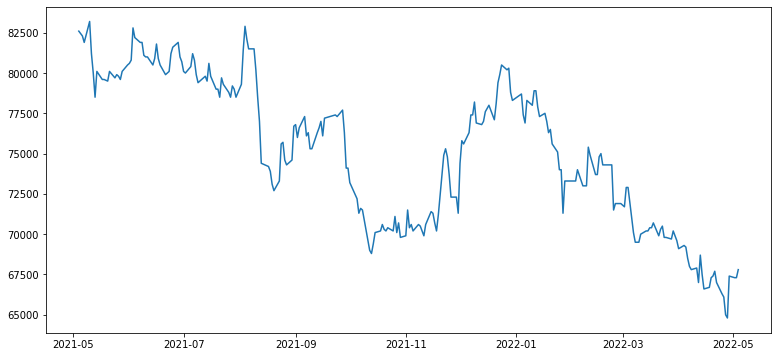

In [5]:
#시각화로 안정성 여부 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts)

origin data의 그래프를 보았을 때 많은 전처리를 해줘야할 것 같은 느낌이 듦.....  

우선, rolling statistics를 통해 평균, 표준편차를 그래프로 시각화 해보고 p-value 값을 확인해보자.

Series([], Name: Close, dtype: float64)


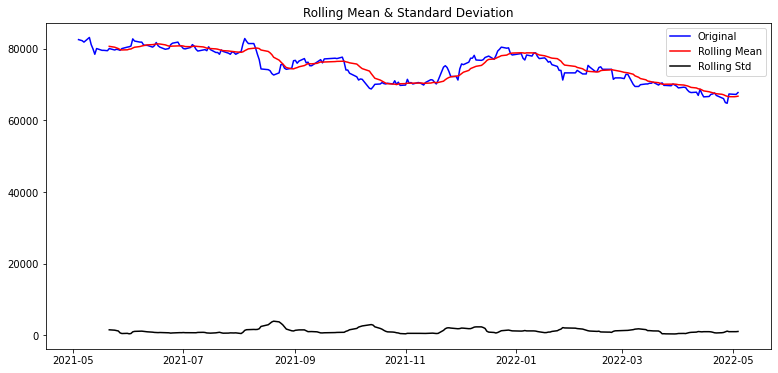

In [6]:
#결측치 유무 확인
ts[ts.isna()]
#결측치 보간해줌
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인
print(ts[ts.isna()])

#rolling statistics를 통해 그래프 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts, window=12)



In [35]:
#Stationary 통계적 확인
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.596445
p-value                          0.485379
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


p-value를 확인해 본 결과 0.48로 생각보다 큰 값을 가지고 있음 -> 시계열이 안정적이지 않은 것으로 보임 -> 안정화 해줘야함


---


### 1) 로그함수 변환하기
- 시간 추이에 따라 분산이 증감하는 것은 확실치 않으나 우선 돌려보기로함

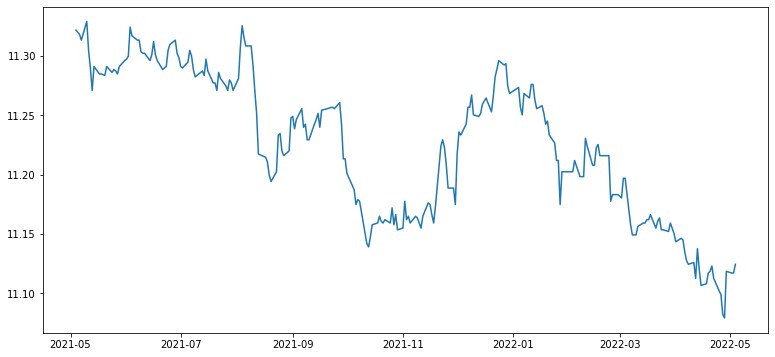

In [8]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [9]:
#로그함수 변환의 효과가 어땠는지 확인하기 위해 다시 ADF test진행
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.547210
p-value                          0.510041
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


기존 **p-value값 0.48에서 0.51로 증가**함.

-> 로그함수변화는 오히려 안정성을 더 높임  
-> origin data가 시간에 따른 평균이 낮아지고 있으니......ㅠㅠ moving average를 제거해보자

---

### 2) 추세(trend) 상쇄하기  
- 시간에 따른 평균값 변화 제거하기

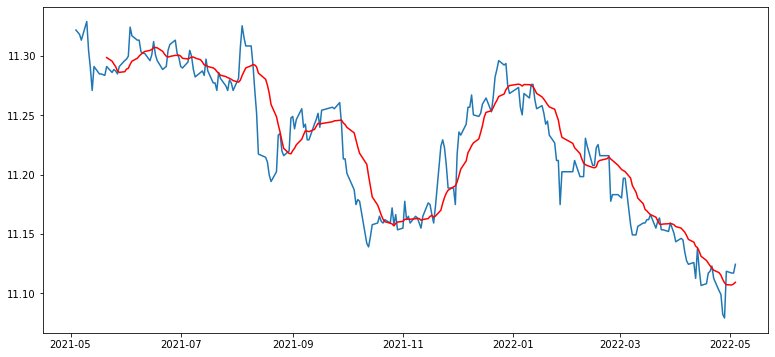

In [10]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

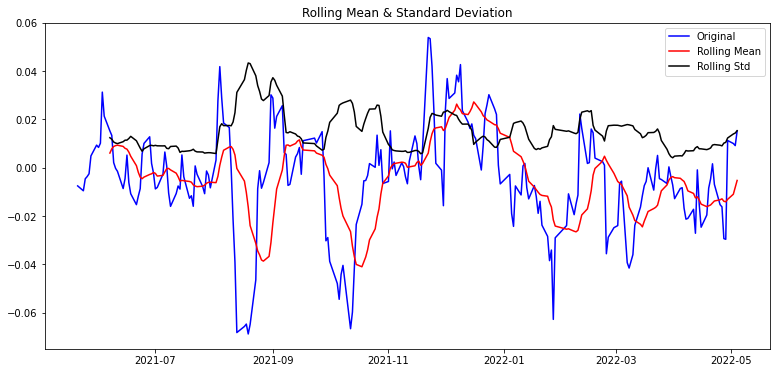

Results of Dickey-Fuller Test:
Test Statistic                  -4.904808
p-value                          0.000034
#Lags Used                       1.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


In [11]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.dropna(inplace=True) #window 값에 따른 결측치 제거
ts_log_moving_avg.head(15) # 값 확인

 #그래프 확인
plot_rolling_statistics(ts_log_moving_avg)
#ADF test 확인
augmented_dickey_fuller_test(ts_log_moving_avg)

p-value값 0.00034로 확실히 감소한 것이 확인되어 안정적인 데이터라고 할 수 있음.

그래프를 봤을땐 안정적이다... 라고 할 수 있을만큼 이쁜 그래프는 아니었는데 p-value 값이 0.0003까지 떨어지다니 신기하네...  

생각해보니 y축의 크기가 상기 그래프들의 축보다 확연히 작아진것을 생각하지 못했다! 이런 기본적인걸...

## STEP 3 : 시계열 안정성 분석

---

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

앞에서 그래프 분석 및 ADF test를 진행했으니 시계열 분해, Residual 안정성 확인을 이어서 해보자.

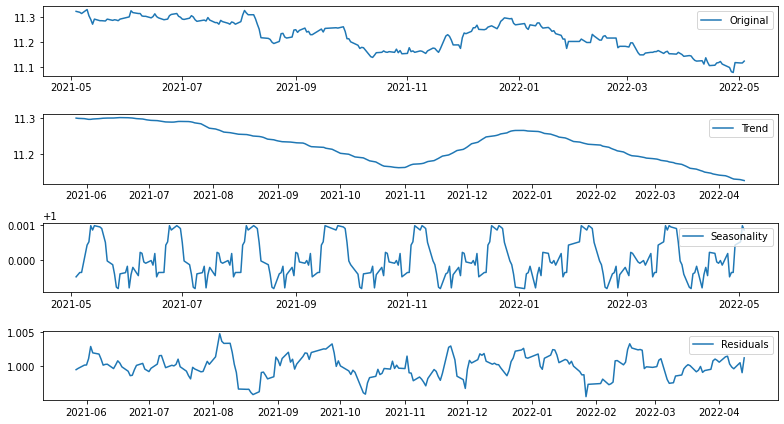

In [14]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

# decomposition = seasonal_decompose(ts_log, freq=12) 
#freq 설정해주지 않으면 오류남 -> 월별 데이터니까 12로 선택

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



multiplication 참고 자료 : https://dodonam.tistory.com/89

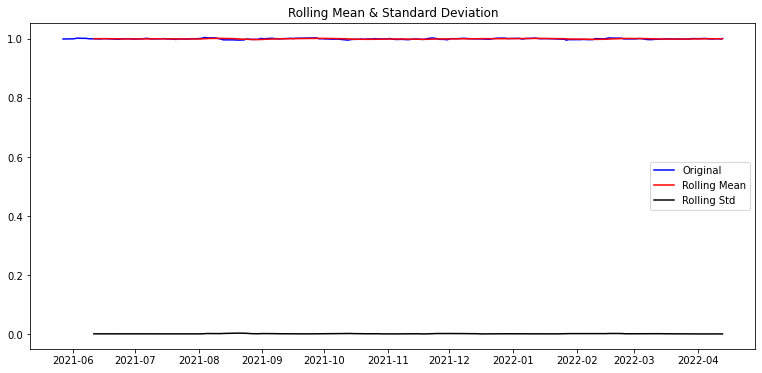

Results of Dickey-Fuller Test:
Test Statistic                  -5.458259
p-value                          0.000003
#Lags Used                       1.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [15]:
#Residual 그래프확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

이 Residual 그래프는 처음엔 당황했으나, 생각해보니 한 그래프상에 origin, mean, std값이 한번에 나와야하니 모양이 이렇게 된게 아닐까 싶다.  

Residual로 처리한 데이터는 std값이 거의 0에 가까울만큼 값들이 정리되었으니까.  

우선 이전 시계열 분석에서 만든 그래프를 통해 각각의 값이 잘 나오는 것을 확인했으며, RDF test를 통해 p-velue값이 압도적으로 작아진 것을 보았으니 그래프는 우선 확인용으로 넘기도록하자.

### STEP 4 : 학습, 테스트 데이터셋 생성

---

- 학습, 테스트 데이터셋 분리

In [16]:
print(ts)

Date
2021-05-04    82600.0
2021-05-06    82300.0
2021-05-07    81900.0
2021-05-10    83200.0
2021-05-11    81200.0
               ...   
2022-04-28    64800.0
2022-04-29    67400.0
2022-05-02    67300.0
2022-05-03    67300.0
2022-05-04    67800.0
Name: Close, Length: 247, dtype: float64


처음 학습, 테스트 데이터셋 분리를 생각했을 때 이전 버전을 생각하고 타입을 바꿔줘야하나? 생각했는데, 생각해보니 이번 것은 sklearn을 사용하여 학습하는 것이 아니니까 데이터 타입은 교체하지 않아도 될 것 같다.

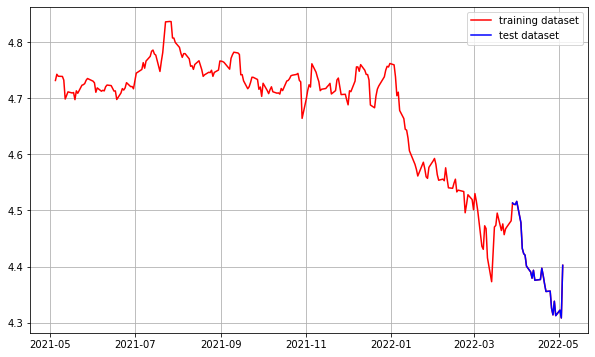

In [141]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):] 
# : 의 위치를 통해 9/1의 비율로 쉽게 나눌 수 있다!
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


### STEP 5 : 적정 ARIMA 모수 찾기

---

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

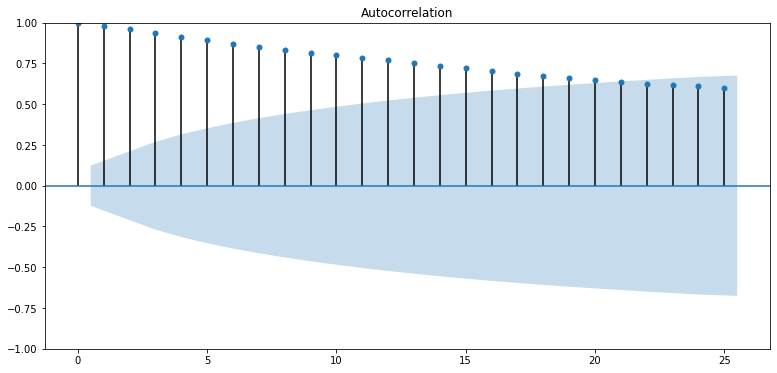

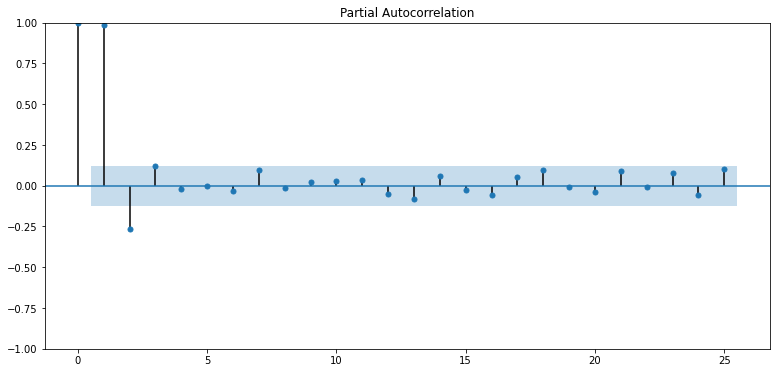

In [143]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

상기 ACF, PACF 그래프를 보았을 때,   
-  ACF 도표가 자기상관이 크고 양수이며, 천천히 감소하는 패턴을 보여주는 것으로 보임  
(유의미한 자기상관이 있는 것이며, 정상적이라면 0에 근접한 자기상관을 보여줌)
- PACF 도표에서는 p=1이 적합해보임.  
 p가 2 이상인 구간에서 PACF가 0에 가까워지는 것을 보아 고려하지 않아도 될 것 같음  

 따라서, ACF를 통한 q = 0, PACF를 통한 p = 1을 선택함

Results of Dickey-Fuller Test:
Test Statistic                -1.486548e+01
p-value                        1.694057e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


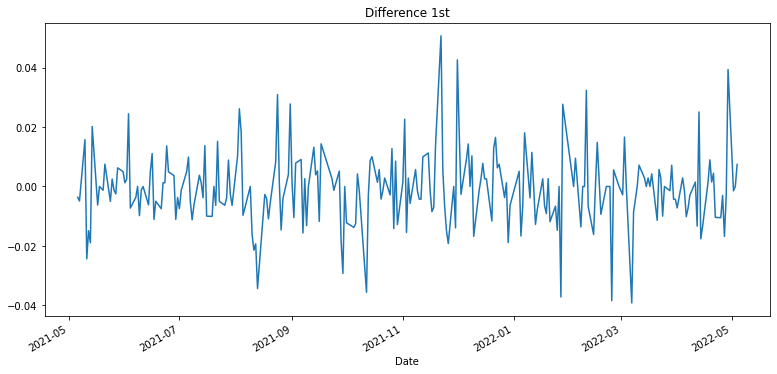

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

d 값을 구하기 위해 1차 차분을 진행했을 때, p-value가 1.694057e-27로 매우 작은 값을 가지고 있어 데이터가 잘 처리되었음을 알 수 있음.  
하지만 혹시 모르니 2차 차분으로 한번 더 진행해보기로함.


Results of Dickey-Fuller Test:
Test Statistic                -7.463991e+00
p-value                        5.263125e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


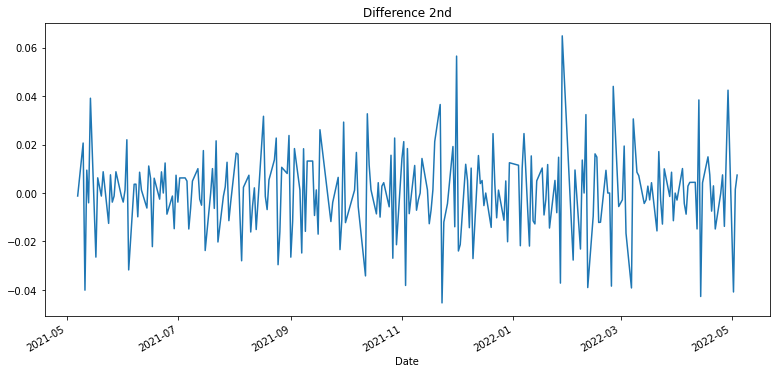

In [20]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 차분으로 돌려보았을 때,   
1.694057e-27 에서 5.263125e-11로 오히려 값이 증가한 것을 알 수 있음   
따라서 d 값은 1로 지정.

### STEP 6 : ARIMA 모델 훈련과 테스트

---


- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [37]:
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore') 

# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) # p=1, d=1, q=0 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 656.947
Date:                Thu, 05 May 2022   AIC                          -1309.895
Time:                        12:41:11   BIC                          -1303.099
Sample:                             0   HQIC                         -1307.151
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0680      0.065      1.042      0.298      -0.060       0.196
sigma2         0.0002   9.98e-06     15.343      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

coef값은 0에서 가장 떨어졌을때 가장 이상적이며 p값은 0과 가장 가까울때가 가장 좋음

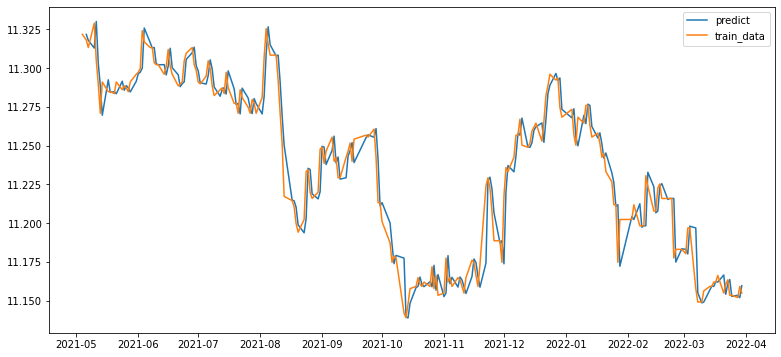

In [32]:
#시각화 진행
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

부분적으로 살짝 회향하는 값들이 있긴 하지만 흐름이 유사한 것을 보아 이정도라면 내 돈을 넣는다고 가정했을 때,,,, 괜찮다고 생각된다.

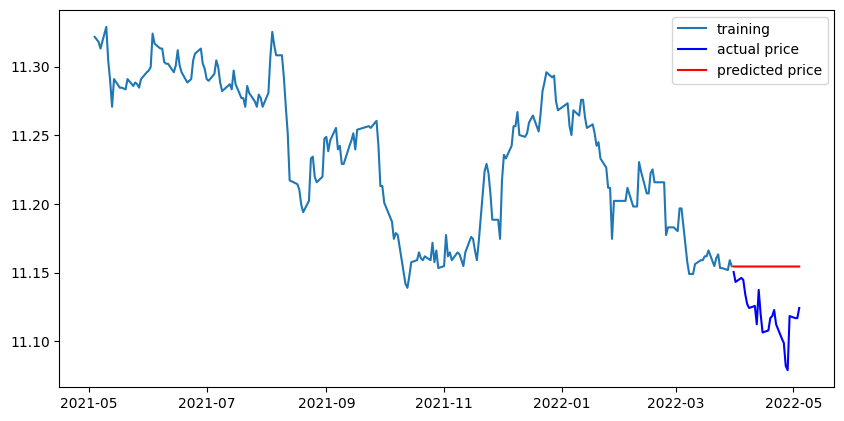

In [41]:
#forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% 
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

이게... 맞나...? 실제값과 prediction값이 전혀 맞지 않는다... 삼성이 문제인가 내 코드가 문제인가...  

어디 학습이 잘됐는지 확인하기위해 전에 사용한 sklearn의 mse, rmse와 회귀모형의 성능을 확인하는 MAPE값을 확인해보자  

- MAPE란 Mean of Absolute Percentage Error의 약자로 이름 그대로 예측 오차의 절대값을 씌워 퍼센트로 나타낸 것이라고 보면 되고, 0에 가까울 수록 좋다

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  7101742.082844112
MAE:  2386.225146319989
RMSE:  2664.90939486582
MAPE: 3.57%


MAPE가 3%대로 예측 오차는 작다고 볼 수 있을 것 같다.  
또한 RMSE가 전 평가 기준이었던 3,000 이하로 내려갔으니 이 또한 좋은 값을 나타내고 있어 학습은 잘되었다고 볼 수 있을 것 같다.  



## 다른 주식 종목 예측해보기

---



### 1. STARBUCKS (우리들의 영원한 별다방)

---

In [53]:
ls '/content/drive/MyDrive/COLAB_data/'

005930.KS.csv  122870.KQ.csv  SBUX.csv


### 1. 시계열 데이터 준비

In [102]:

#구글 코랩 데이터 불러오기
from google.colab import drive
drive.mount("/content/drive")
data_path = '/content/drive/MyDrive/COLAB_data/SBUX.csv'

# Time Series 생성
import warnings
warnings.filterwarnings('ignore')

df_SB = pd.read_csv(data_path, index_col='Date', parse_dates=True) 
ts_SB = df_SB['Close']

ts_SB.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Date
2021-05-05    113.480003
2021-05-06    114.739998
2021-05-07    114.339996
2021-05-10    114.300003
2021-05-11    113.550003
Name: Close, dtype: float64

### 2. 전처리 수행

---

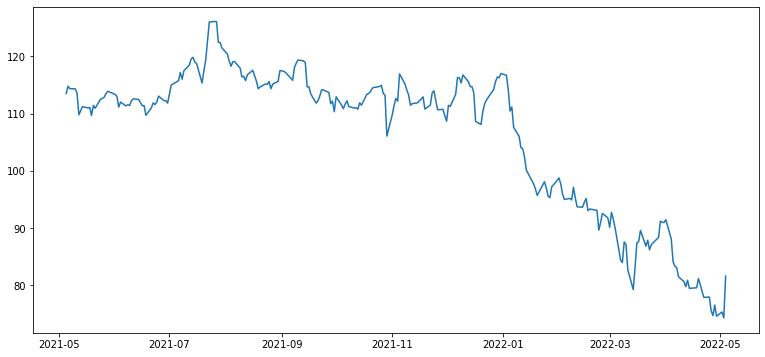

In [103]:
#시각화로 안정성 여부 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts_SB)

우주최강 스벅은 21년이 마지막인가...  

슬프지만 과제를 해야하니 Origin 그래프의 p-value 값을 구하고 그래프를 그려보자

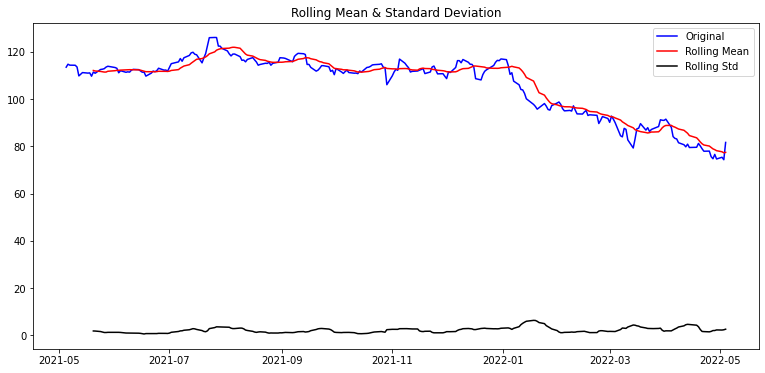

In [105]:
ts_SB[ts_SB.isna()]#결측치 없으니 그냥 진행

#rolling statistics를 통해 그래프 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_SB, window=12)

In [106]:
#Stationary 통계적 확인
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_SB)

Results of Dickey-Fuller Test:
Test Statistic                  -0.261606
p-value                          0.930769
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


세상에 p-value가 0.9로 굉장히 불안정한 값이다...   
어서 전처리를 진행하자!

### 1) 로그함수 변환
- 시간에 따른 분산의 증감이 없어 큰 효과는 없을 것 같으나 우선 차례대로 돌려보자



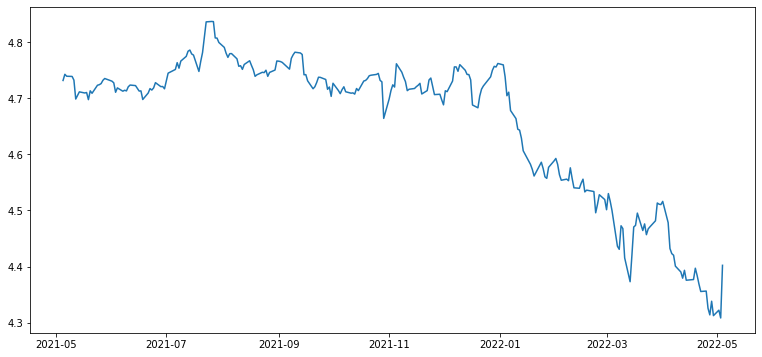

In [107]:
ts_log_SB = np.log(ts_SB)
plt.plot(ts_log_SB)

In [108]:
#로그함수 변환의 효과가 어땠는지 확인하기 위해 다시 ADF test진행
augmented_dickey_fuller_test(ts_log_SB)

Results of Dickey-Fuller Test:
Test Statistic                  -0.228969
p-value                          0.934979
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


역시나 **p-value 값이 오히려 증가**했다.  
추세 상쇄로 고고

---

### 2)추세 상쇄하기



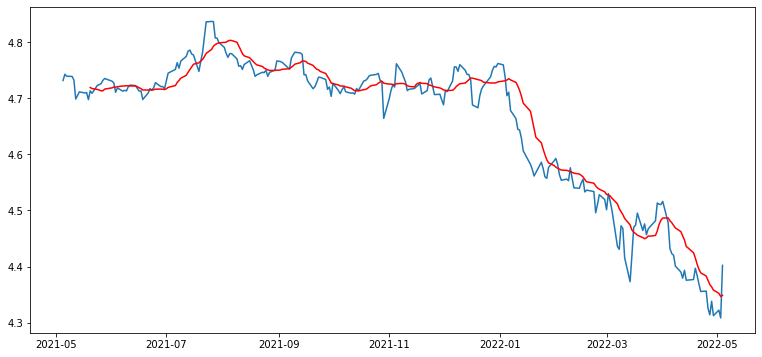

In [110]:
moving_avg_SB = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg_SB, color='red')

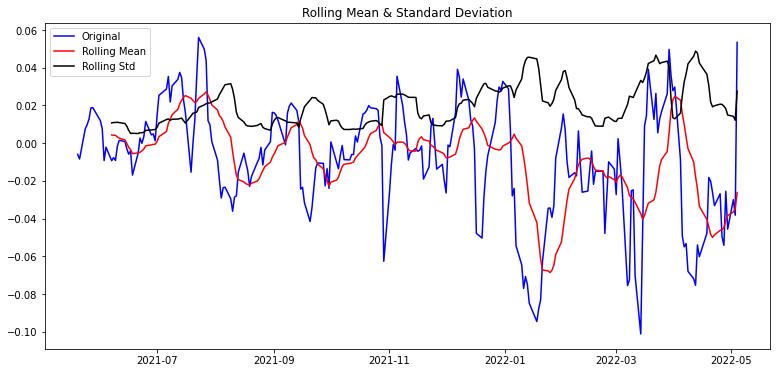

Results of Dickey-Fuller Test:
Test Statistic                  -5.071815
p-value                          0.000016
#Lags Used                       4.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


In [111]:
ts_log_moving_avg_SB = ts_log - moving_avg 
ts_log_moving_avg_SB.dropna(inplace=True) #window 값에 따른 결측치 제거
ts_log_moving_avg_SB.head(15) # 값 확인시 결측치 없음

#그래프 확인
plot_rolling_statistics(ts_log_moving_avg_SB)
#ADF test 확인
augmented_dickey_fuller_test(ts_log_moving_avg_SB)

p-value가 0.000016까지 확 떨어져 안정적인 데이터라고 할 수 있으니, 이후 과정을 진행하자

### 3. 시계열 안정성 분석

---

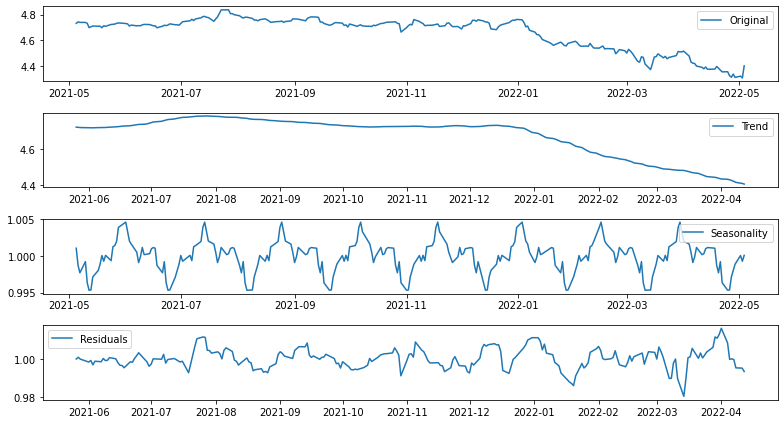

In [112]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_SB, model='multiplicative', period = 30)

trend_SB = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal_SB = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_SB = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log_SB, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_SB, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_SB,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_SB, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

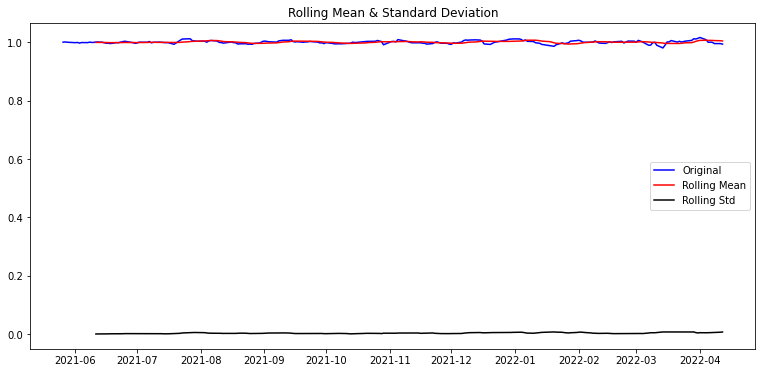

Results of Dickey-Fuller Test:
Test Statistic                  -5.453533
p-value                          0.000003
#Lags Used                       4.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


In [113]:
#Residual 그래프확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual_SB)

#Residual 안정성 확인
residual_SB.dropna(inplace=True)
augmented_dickey_fuller_test(residual_SB)

### 4. 학습, 테스트 데이터셋 설정

---  

첫번째 삼성 예측시엔 log값으로 진행했었으나, 이젠 Residual로 하는 것이 더 안정적인 데이터를 뽑을 수 있을 것 같아 log 대신 Residual로 진행하기로함

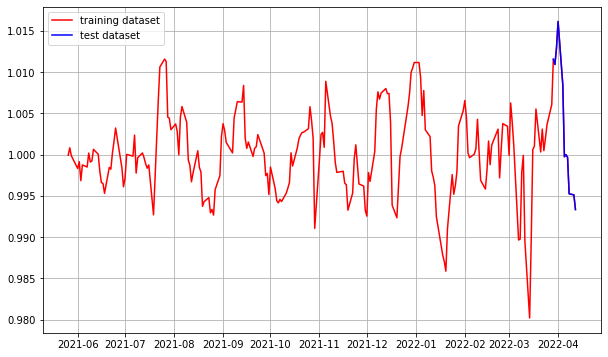

In [114]:
train_data_SB, test_data_SB = residual_SB[:int(len(residual_SB)*0.9)], residual_SB[int(len(residual_SB)*0.9):] 

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(residual_SB, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기

---

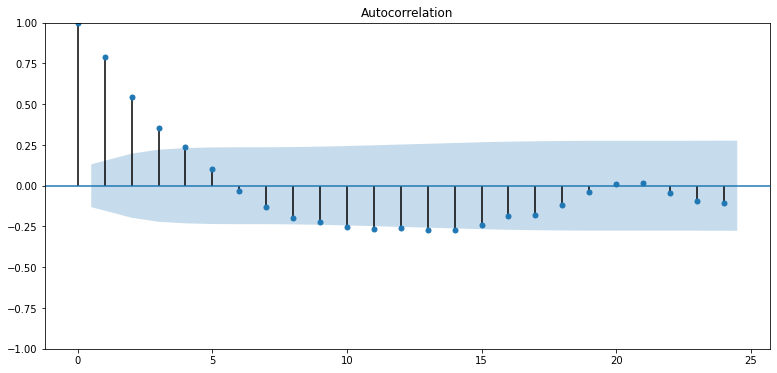

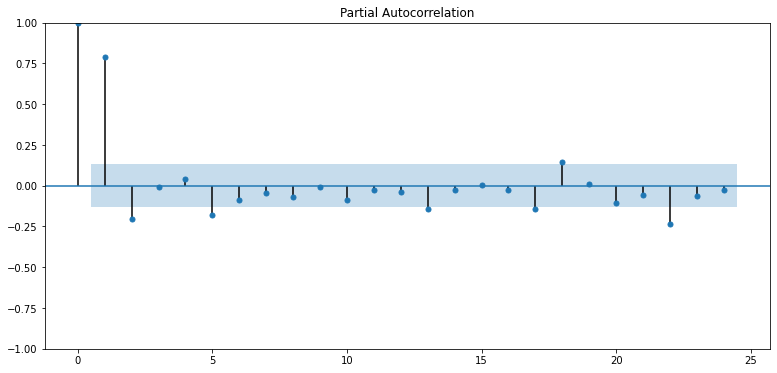

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residual_SB)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(residual_SB)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

상기 그래프를 통해 PACF도표의 p = 1 이 적합함을 확인함

따라서 p = 1, q = 0을 선택. d를 구하기 위한 차분 진행!

Results of Dickey-Fuller Test:
Test Statistic                -1.038984e+01
p-value                        2.034529e-18
#Lags Used                     2.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


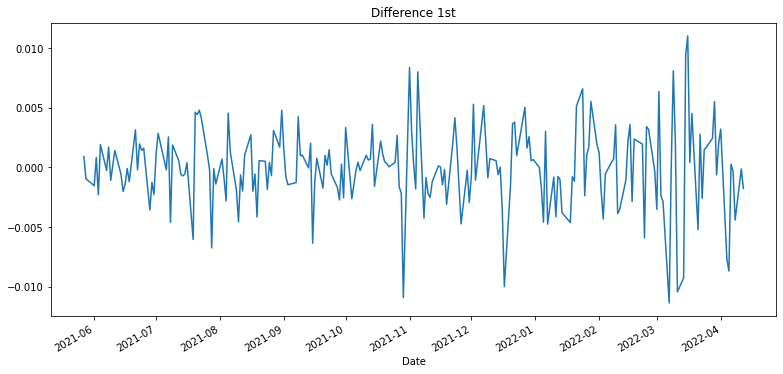

In [116]:
# 1차 차분 구하기
diff_1_SB = residual_SB.diff(periods=1).iloc[1:]
diff_1_SB.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_SB)

Results of Dickey-Fuller Test:
Test Statistic                -8.527222e+00
p-value                        1.061137e-13
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


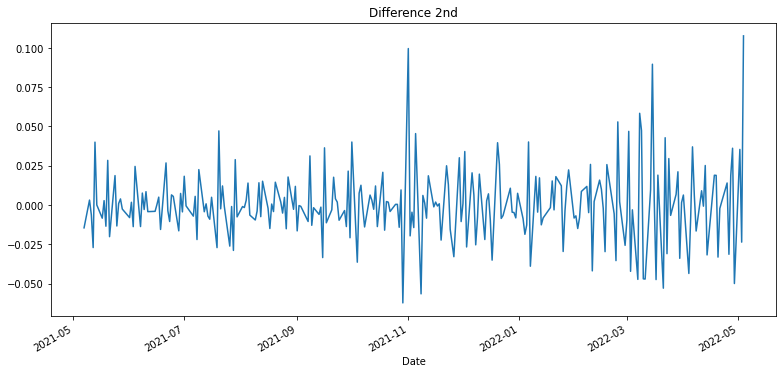

In [117]:
# 2차 차분 구하기
diff_2_SB = diff_1.diff(periods=1).iloc[1:]
diff_2_SB.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_SB)

2차 차분까지 구해본 결과,  
1차분의 p-value 값이 2.034529e-18로 굉장히 낮아 d = 1로 결정함

### 6. ARIMA 모델 훈련과 테스트

---

In [131]:
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore') 

# Build Model
model = ARIMA(train_data_SB, order=(1, 1, 0)) # p=1, d=1, q=0 
fitted_m_SB = model.fit() 

print(fitted_m_SB.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  200
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 871.692
Date:                Thu, 05 May 2022   AIC                          -1739.384
Time:                        14:36:20   BIC                          -1732.797
Sample:                             0   HQIC                         -1736.718
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0503      0.059      0.852      0.394      -0.065       0.166
sigma2      9.149e-06   6.71e-07     13.636      0.000    7.83e-06    1.05e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [132]:
print(type(fitted_m_SB))

<class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>


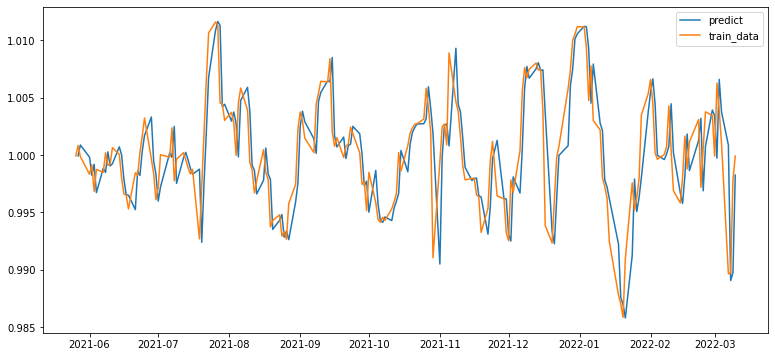

In [135]:
#시각화 진행
fitted_m_SB1 = fitted_m_SB.predict()
fitted_m_SB1 = fitted_m_SB1.drop(fitted_m_SB1.index[0])
plt.plot(fitted_m_SB1, label='predict')
plt.plot(train_data_SB, label='train_data')
plt.legend()

호오... 눈으로 간단히 보니, 앞서 진행한 삼성보다 튀는 값이 적어 맘에든다.

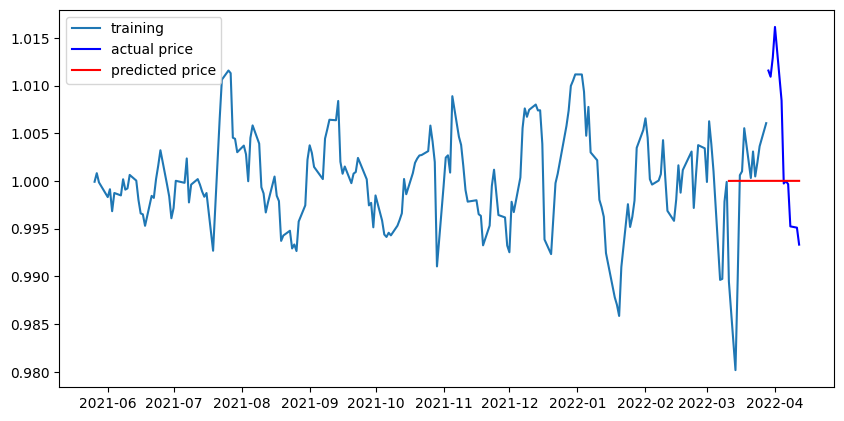

In [137]:
#forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
fc = fitted_m_SB.forecast(len(test_data_SB), alpha=0.05)  # 95% 
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data_SB.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

prediced price가 Actual Price의 중간정도를 지나가는 것을 보아, 예측이 잘 된것 같지만 확실하게 하기위해 rmse, mape를 확인하자!

In [138]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data_SB), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_SB), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_SB), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data_SB))/np.abs(np.exp(test_data_SB)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0004977757546512277
MAE:  0.016586520637320502
RMSE:  0.02231088870151137
MAPE: 0.61%


와우 RMSE:  0.02, MAPE 0.61%로 만족스러운 fit을 뽑은 것 같아 기분이 좋다^_^  

이를 통해 log보다 정리된 Residual을 사용하는 것이 확연하게 좋은 값을 뽑아낼 수 있다는 것을 알았으니, 이후부턴 계속 Residual을 사용하자

### 2. APPLE (사과간지)

---


In [144]:
ls /content/drive/MyDrive/COLAB_data/

005930.KS.csv  033780.KS.csv  122870.KQ.csv  AAPL.csv  SBUX.csv


In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#구글 코랩 데이터 불러오기
from google.colab import drive
drive.mount("/content/drive")
data_path = '/content/drive/MyDrive/COLAB_data/AAPL.csv'

# Time Series 생성
import warnings
warnings.filterwarnings('ignore')

df_AP = pd.read_csv(data_path, index_col='Date', parse_dates=True) #시계열로 불러야하니까 index 및 parse_dates 추가해줌
ts_AP = df_AP['Close']

ts_AP.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Date
2021-05-05    128.100006
2021-05-06    129.740005
2021-05-07    130.210007
2021-05-10    126.849998
2021-05-11    125.910004
Name: Close, dtype: float64

두둥탁. 우선 사과언니의 그래프와 rollong statistics를 통해 시각화 및 origin 값의 p-value값을 확인하여 데이터 처리 유무를 확인하자(물론 당연히 해야겠지만..)

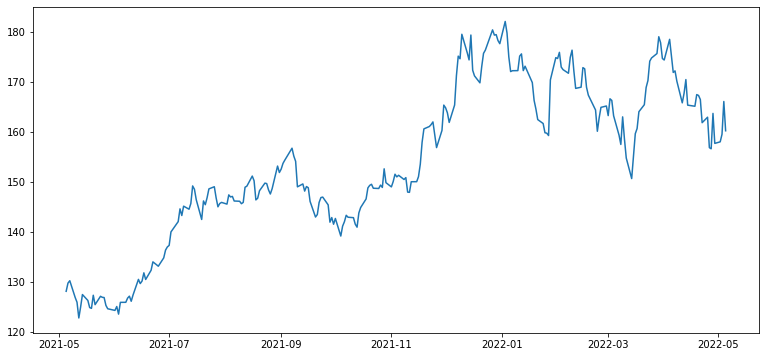

In [147]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts_AP)

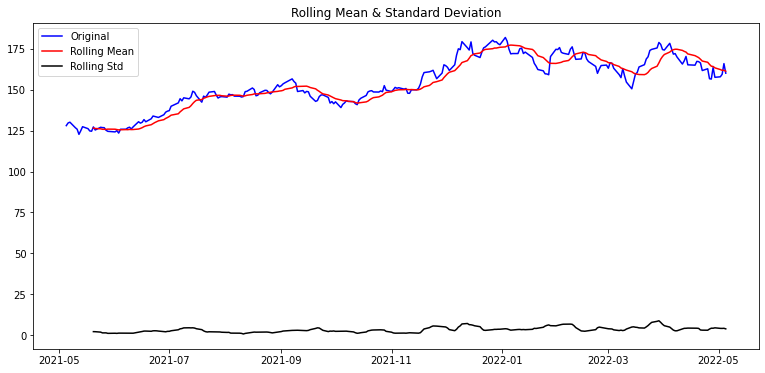

In [150]:
ts_AP[ts_AP.isna()] #결측치값이 없음을 확인하여 보간작업 건너뜀

#rolling statistics를 통해 그래프 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_AP, window=12)

In [151]:
#Stationary 통계적 확인
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_AP)

Results of Dickey-Fuller Test:
Test Statistic                  -1.889841
p-value                          0.336855
#Lags Used                       8.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


사과언니의 p-value 값이 0.33으로 생각보단 안정적이나, 더욱 안정적인 데이터를 위해 전처리를 진행하자  

##2. 전처리 수행

---

Results of Dickey-Fuller Test:
Test Statistic                  -1.971416
p-value                          0.299245
#Lags Used                       8.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


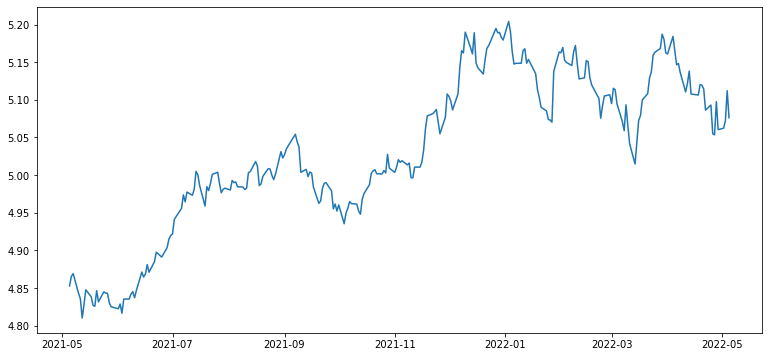

In [154]:
#1) 로그함수 변환 및 ADF TEST
ts_log_AP = np.log(ts_AP)
plt.plot(ts_log_AP)

augmented_dickey_fuller_test(ts_log_AP)

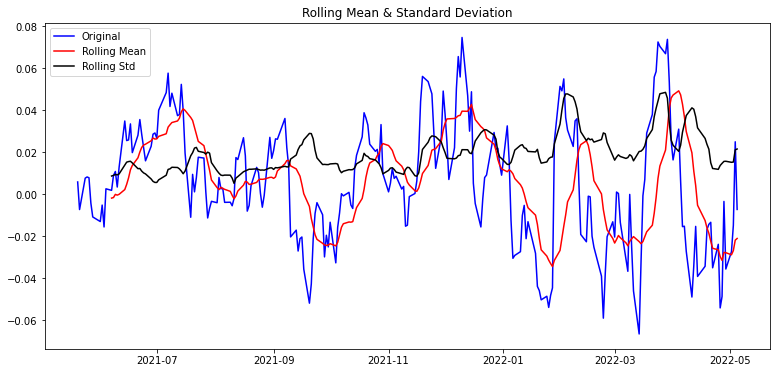

Results of Dickey-Fuller Test:
Test Statistic                  -3.937772
p-value                          0.001774
#Lags Used                       8.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


In [156]:
#2) 추세상쇄 하기

moving_avg_AP = ts_log_AP.rolling(window=12).mean() 
ts_log_moving_avg_AP = ts_log_AP - moving_avg_AP 
ts_log_moving_avg_AP.dropna(inplace=True) 

 #그래프 확인
plot_rolling_statistics(ts_log_moving_avg_AP)
#ADF test 확인
augmented_dickey_fuller_test(ts_log_moving_avg_AP)

추세 변환까지 하여 p-value가 0.001까지 떨어진것을 확인했으니 이후 시계열 안정성까지 확인해보자  

###3. 시계열 안정성 분석

---

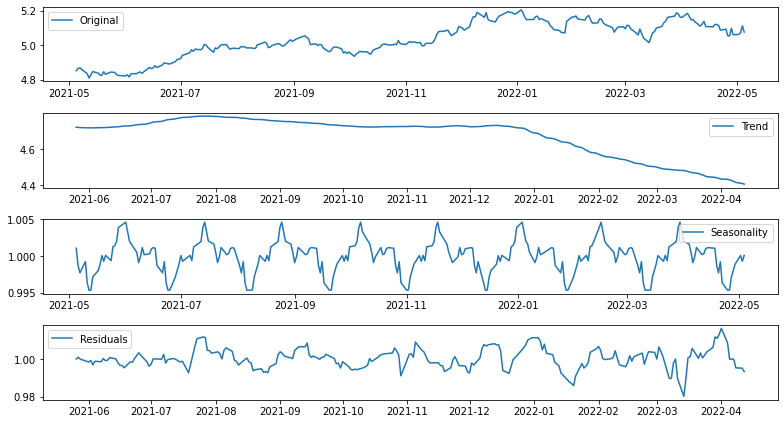

In [157]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

# decomposition = seasonal_decompose(ts_log, freq=12) 
#freq 설정해주지 않으면 오류남 -> 월별 데이터니까 12로 선택

trend_AP = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal_AP = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_AP = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log_AP, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_AP, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_AP,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_AP, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

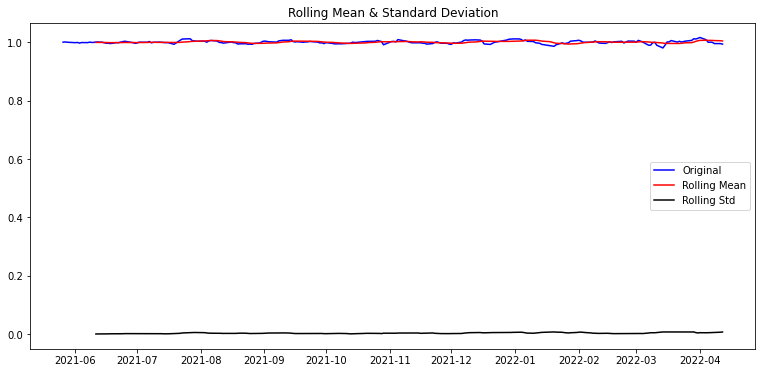

Results of Dickey-Fuller Test:
Test Statistic                  -5.453533
p-value                          0.000003
#Lags Used                       4.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


In [158]:
#Residual 그래프확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual_AP)

#Residual 안정성 확인
residual_AP.dropna(inplace=True)
augmented_dickey_fuller_test(residual_AP)

캬.. Residual을 하니 p-value 값이 0.000003까지 떨어진 것을 확인했다. 이후 진행할 값은 가장 안정적 데이터인 Residual을 사용하자.

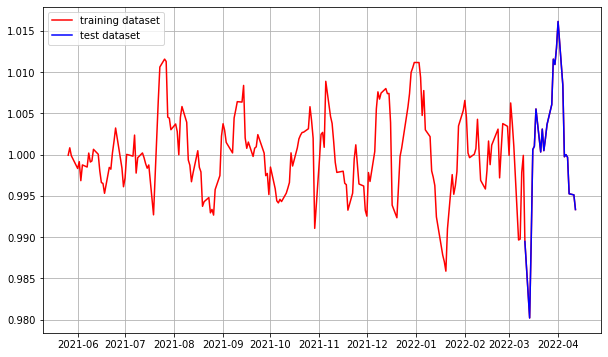

In [159]:
train_data_AP, test_data_AP = residual_AP[:int(len(residual_AP)*0.9)], residual_AP[int(len(residual_AP)*0.9):] 

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(residual_AP, c='r', label='training dataset')  
plt.plot(test_data_AP, c='b', label='test dataset')
plt.legend()

###5. 적정 ARIMA 모수찾기

---

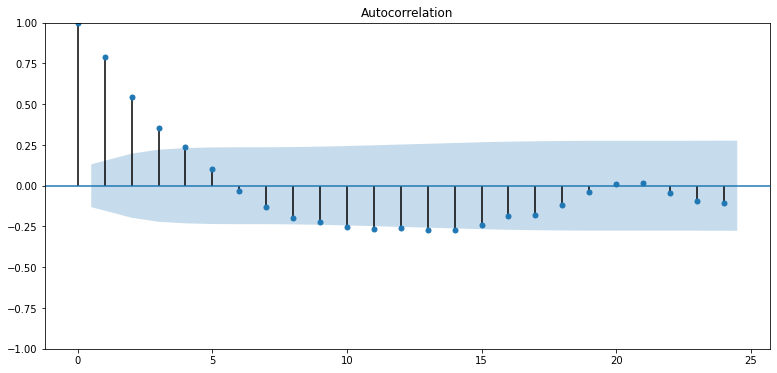

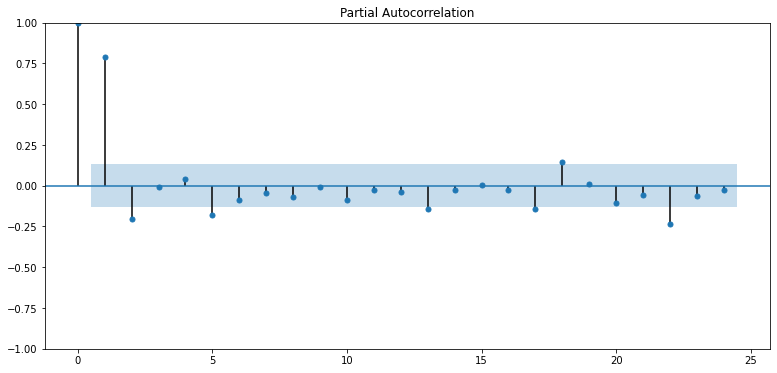

In [160]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residual_AP)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(residual_AP)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.038984e+01
p-value                        2.034529e-18
#Lags Used                     2.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


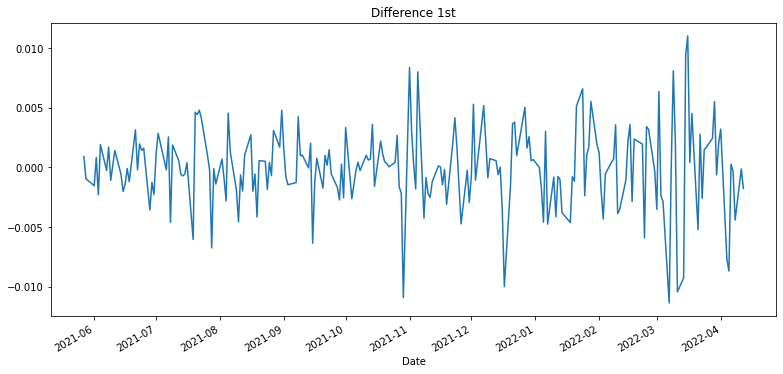

In [162]:
# 1차 차분 구하기
diff_1_AP = residual_AP.diff(periods=1).iloc[1:]
diff_1_AP.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_AP)


Results of Dickey-Fuller Test:
Test Statistic                -6.867597e+00
p-value                        1.544797e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


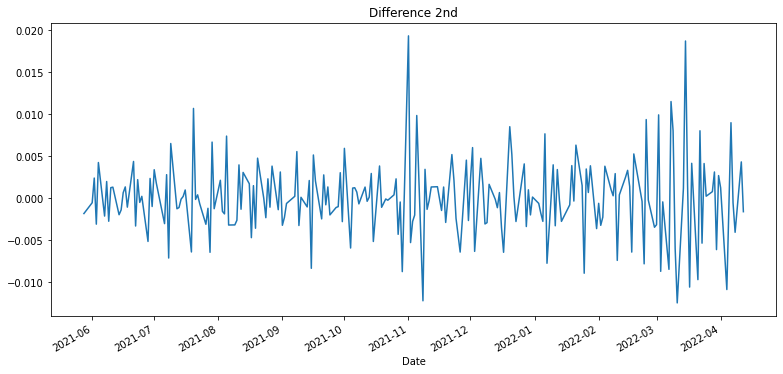

In [163]:
# 2차 차분 구하기
diff_2_AP = diff_1_AP.diff(periods=1).iloc[1:]
diff_2_AP.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_AP)

상기 ACF, PACF그래프를 통해  값은 p = 0, q = 1로 선택하고,    
1,2차 차분의 ADF test를 통해 p-value값이 더 낮은 1차 차분을 선택함(d = 1).



###6. ARIMA 모델 훈련과 테스트
---

In [164]:
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore') 

# Build Model
model = ARIMA(train_data_AP, order=(1, 1, 0)) # p=1, d=1, q=0 
fitted_m_AP = model.fit() 

print(fitted_m_AP.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  200
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 871.692
Date:                Thu, 05 May 2022   AIC                          -1739.384
Time:                        15:27:47   BIC                          -1732.797
Sample:                             0   HQIC                         -1736.718
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0503      0.059      0.852      0.394      -0.065       0.166
sigma2      9.149e-06   6.71e-07     13.636      0.000    7.83e-06    1.05e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

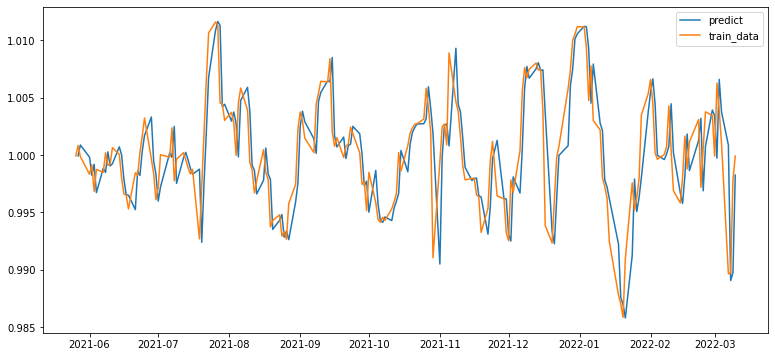

In [166]:
#시각화 진행
fitted_m_AP1 = fitted_m_AP.predict()
fitted_m_AP1 = fitted_m_AP1.drop(fitted_m_AP1.index[0])
plt.plot(fitted_m_AP1, label='predict')
plt.plot(train_data_AP, label='train_data')
plt.legend()

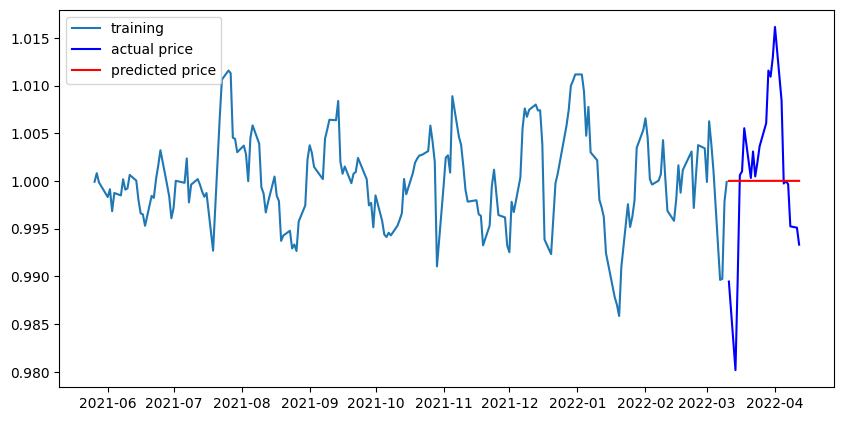

In [167]:
#forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
fc = fitted_m_AP.forecast(len(test_data_AP), alpha=0.05)  # 95% 
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data_AP.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_AP, label='training')
plt.plot(test_data_AP, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

예측한 시각화 값들이 아주 이쁜 그래프를 그리고 있다... 나 주식 고수 될지도...?

In [168]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data_AP), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_AP), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_AP), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data_AP))/np.abs(np.exp(test_data_AP)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0004977757546512277
MAE:  0.016586520637320502
RMSE:  0.02231088870151137
MAPE: 0.61%


RMSE값도, MAPE값도 아주 흡족스럽다!  

다음엔, 적금보다 안정적이라는 KT&G주식으로 origin 모델이 안정적일땐 어느정도 예측할 수 있는지 시도해보자.  



##3. KT&G (가랏! K-담배, k-홍삼, K-녹용!!!)

---